In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.LSTM_fQuadSinHF.recursive_LSTM_PostMeanScore_fQuadSinHF_T256_H05_tl_110data import \
    get_config

In [2]:
config = get_config()
deltaT = config.deltaT
print(config.loss_factor)
local_bw_rmses = {}
global_bw_rmses = {}

2


0.01096772369653112 0.0007545149628051234 inf


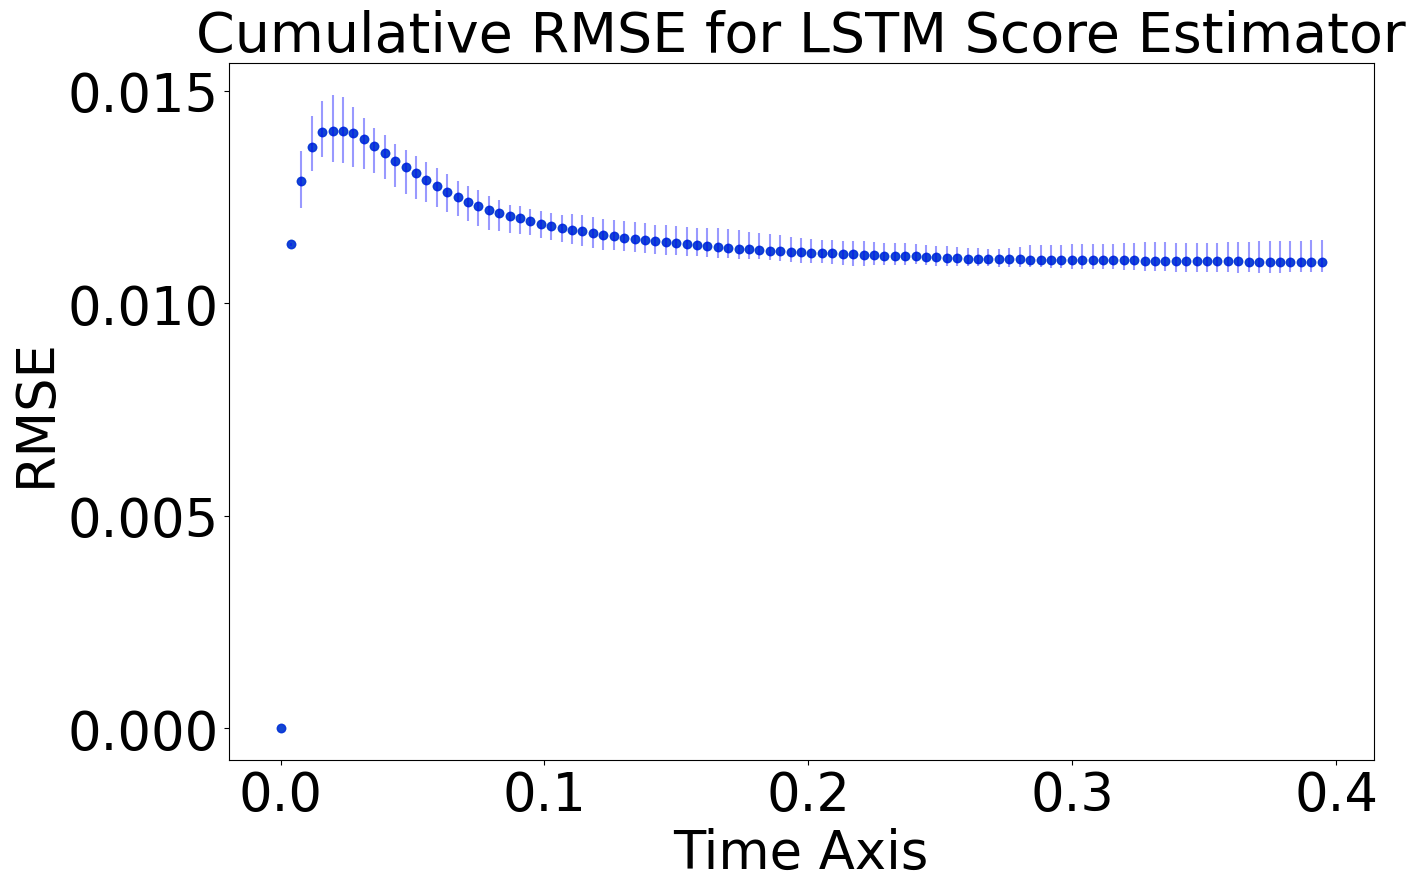

Final time cumulative RMSE local-time error 0.01096772369653112 with final IQR (0.010729865158855321, 0.011484380121660445) at Nepoch 60

0.0164835143565047 0.00058217263425768 0.01096772369653112
0.006735838252781456 0.0005898636668905683 0.01096772369653112


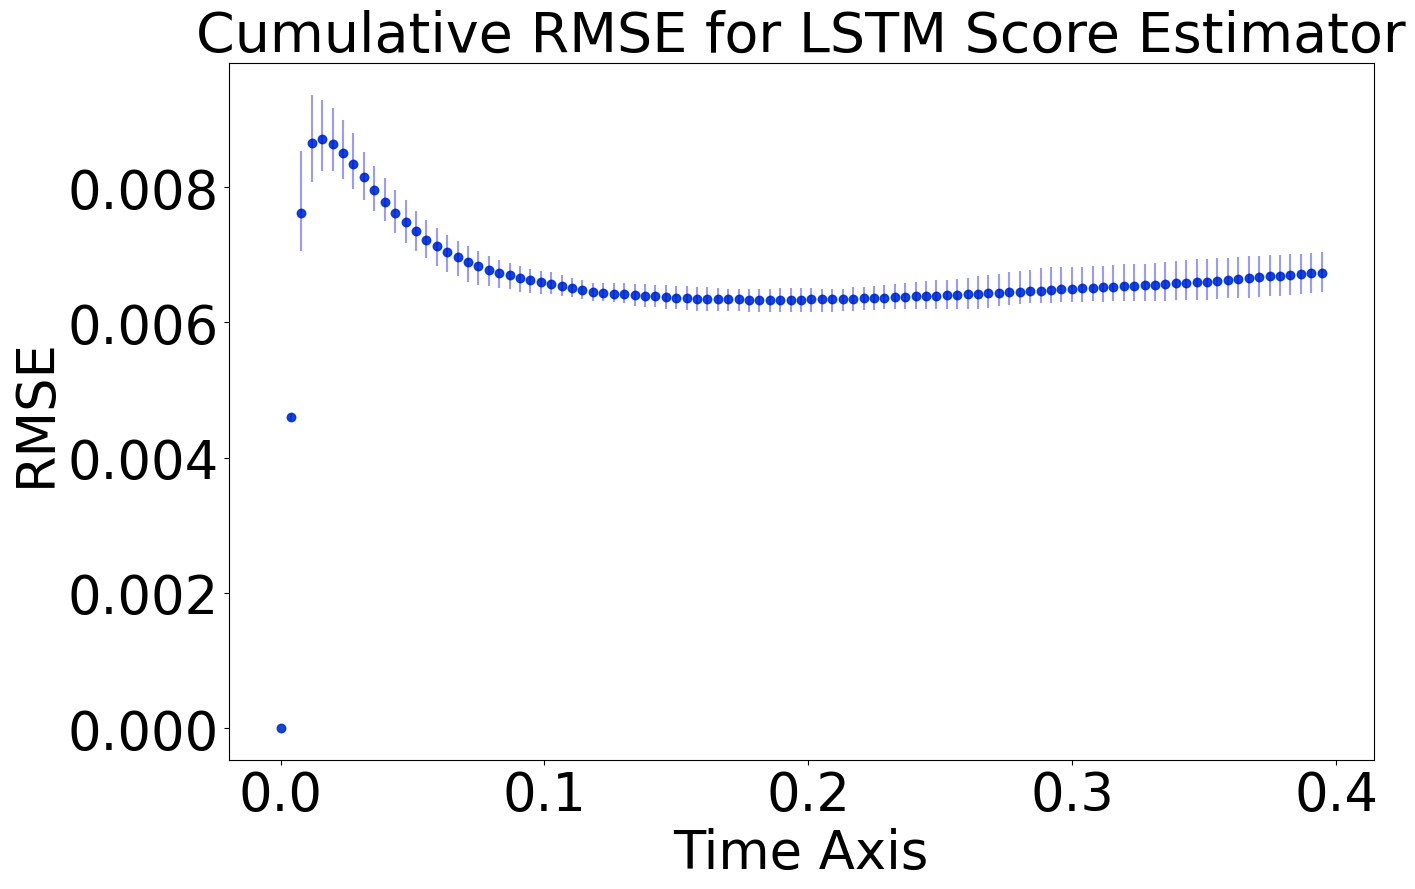

Final time cumulative RMSE local-time error 0.006735838252781456 with final IQR (0.006443685599297115, 0.007033549266187683) at Nepoch 150

0.01023009060550248 0.0004729345254750276 0.006735838252781456
0.00729631103363579 0.0007177478519961736 0.006735838252781456
0.01502263165876853 0.0012798466573515997 0.006735838252781456
0.015781154452508266 0.0013280499060446486 0.006735838252781456
0.009311799452341202 0.000823091182670297 0.006735838252781456
0.015169515254646392 0.000802086115390007 0.006735838252781456
0.01578467726034726 0.0016222608412907718 0.006735838252781456
0.00943561656355749 0.001246941117778285 0.006735838252781456
0.011164663504586104 0.0006922750344915563 0.006735838252781456
0.0188432480136724 0.0013404066469910499 0.006735838252781456


In [4]:
curr_rmse = np.inf
toSave = True
for Nepoch in config.max_epochs:
    try:
        if "_ST_" in config.scoreNet_trained_path:
            save_path = (
                    project_config.ROOT_DIR + f"experiments/results/TSPM_LSTM_ST_fQuadSinHF_OOSDriftTrack_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c_{config.residual_layers}ResLay_{config.loss_factor}LFac").replace(
                ".", "")
        else:
            save_path = (
                    project_config.ROOT_DIR + f"experiments/results/TSPM_LSTM_fQuadSinHF_OOSDriftTrack_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c_{config.residual_layers}ResLay_{config.loss_factor}LFac").replace(
                ".", "")

        all_true_states = np.load(save_path + "_true_states.npy")/np.sqrt(config.deltaT)
        all_local_states= np.load(save_path + "_local_states.npy")/np.sqrt(config.deltaT)
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean(np.sqrt(all_local_errors), axis=0)
        total_local_errors_minq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.025)
        total_local_errors_maxq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.975)
        print(total_local_errors[-1], total_local_errors_maxq[-1]-total_local_errors_minq[-1], curr_rmse)
        if total_local_errors[-1]  < curr_rmse:
            time_steps = np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0])
            curr_rmse = total_local_errors[-1] #- total_local_errors_minq[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            ax.scatter(time_steps, total_local_errors)
            #plt.fill_between(time_steps, total_local_errors_minq, total_local_errors_maxq, color="blue", alpha=0.2, label="95% Confidence Band")
            plt.errorbar(time_steps,total_local_errors,yerr=[total_local_errors-total_local_errors_minq, total_local_errors_maxq-total_local_errors],xerr=None, fmt='o', color="blue", alpha=0.4)
            ax.set_title(f"Cumulative RMSE for LSTM Score Estimator",fontsize=40)
            ax.set_ylabel("RMSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/fQuadSinHF_OOSDriftTrack_{Nepoch}Nep_PM_LSTM_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative RMSE local-time error {(total_local_errors[-1])} with final IQR {total_local_errors_minq[-1], total_local_errors_maxq[-1]} at Nepoch {Nepoch}\n")
    except FileNotFoundError as e:
        print(e)
        continue